<a href="https://colab.research.google.com/github/BlueLarddd/a1/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22work%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачиваем нужные библиотеки

In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib opencv-python

# Загружаем датасет

In [ ]:
import requests
from urllib.parse import urlencode
import patoolib
import os

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/5cV2jxYlKA3GCQ'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
downloaded_file_path = '/content/symbols.rar'

with open(downloaded_file_path, 'wb') as f:
    f.write(download_response.content)

# Разархивируем файл
extracted_path = '/content/extracted/'

# Проверяем, существует ли папка для распаковки, и создаем ее при необходимости
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Распаковываем скачанный архив
patoolib.extract_archive(downloaded_file_path, outdir=extracted_path)

# Удаляем изначальный архив
os.remove(downloaded_file_path)

INFO patool: Extracting /content/symbols.rar ...
INFO:patool:Extracting /content/symbols.rar ...
INFO patool: running /usr/bin/unrar x -- /content/symbols.rar
INFO:patool:running /usr/bin/unrar x -- /content/symbols.rar
INFO patool:     with cwd='/content/extracted/', input=''
INFO:patool:    with cwd='/content/extracted/', input=''
INFO patool: ... /content/symbols.rar extracted to `/content/extracted/'.
INFO:patool:... /content/symbols.rar extracted to `/content/extracted/'.


In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
def preprocess_image(image_path):
    # Загрузка изображения
    img = cv2.imread(image_path)

    # Изменение размера изображения
    img = cv2.resize(img, (32, 32))

    return img

In [ ]:
def show_images(original, preprocessed, title1='Original Image', title2='Preprocessed Image'):
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed, cmap='gray')
    plt.title(title2)
    plt.axis('off')

    plt.show()

# Находим объект на изображении

In [ ]:
def resize_and_center_crop(image_path, target_size=(55, 55)):
    # Загрузка изображения
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Применение адаптивного выравнивания гистограммы или других шагов предобработки по желанию
    # ...

    # Применение фильтра для выделения контуров
    edged = cv2.Canny(img, threshold1=30, threshold2=100)

    # Нахождение контуров в изображении
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Выбираем самый большой контур
        largest_contour = max(contours, key=cv2.contourArea)

        # Получаем ограничивающий прямоугольник вокруг контура
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Рассчитываем центр ограничивающего прямоугольника
        center_x = x + w // 2
        center_y = y + h // 2

        # Рассчитываем координаты для обрезки изображения
        left = max(0, center_x - target_size[0] // 2)
        top = max(0, center_y - target_size[1] // 2)
        right = min(img.shape[1], center_x + target_size[0] // 2)
        bottom = min(img.shape[0], center_y + target_size[1] // 2)

        # Обрезаем изображение согласно координатам
        cropped_img = img[top:bottom, left:right]

        # Нормализация значений пикселей
        cropped_img = cropped_img / 255.0

        # Изменение размера до целевых размеров
        cropped_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)

        return cropped_img

    else:
        print(f"Контуры не найдены {image_path}.")
        return None

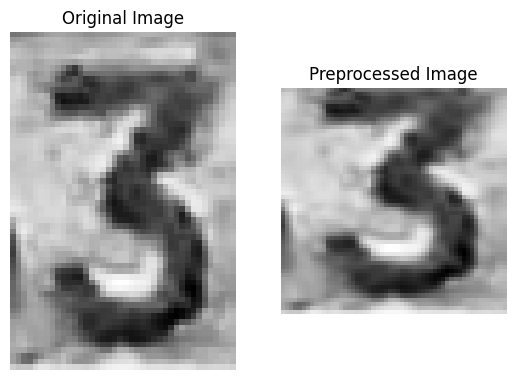

(55, 55)


In [ ]:
image_path = "/content/extracted/3/15.bmp"
cropped_image = resize_and_center_crop(image_path)

# Вывод оригинального и обрезанного изображений
show_images(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cropped_image)

print(cropped_image.shape)

# Кропаем все фото в датасете

In [ ]:
# Папка, где хранятся изображения
base_folder = "/content/extracted"

# Функция для обрезки и перезаписи изображений
def process_images(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path):
            # Игнорируем файлы, не являющиеся изображениями
            if not filename.lower().endswith(('.bmp')):
                continue

            # Обрезаем изображение
            cropped_image = resize_and_center_crop(file_path)

            if cropped_image is not None:
                # Перезаписываем изображение в оригинальную папку
                cv2.imwrite(file_path, cropped_image * 255)  # Умножаем на 255 для сохранения в формате изображения (0-255)

# Перебираем все папки в базовой папке
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)

    if os.path.isdir(subfolder_path):
        # Обрабатываем изображения в каждой подпапке
        process_images(subfolder_path)

Контуры не найдены /content/extracted/negative/_694.bmp.
Контуры не найдены /content/extracted/negative/_585.bmp.
Контуры не найдены /content/extracted/negative/_763.bmp.
Контуры не найдены /content/extracted/negative/23113418.bmp.
Контуры не найдены /content/extracted/negative/_610.bmp.
Контуры не найдены /content/extracted/negative/_685.bmp.
Контуры не найдены /content/extracted/negative/14912346.bmp.
Контуры не найдены /content/extracted/negative/415 (2).bmp.
Контуры не найдены /content/extracted/negative/_496.bmp.
Контуры не найдены /content/extracted/negative/355.bmp.
Контуры не найдены /content/extracted/negative/_589.bmp.
Контуры не найдены /content/extracted/negative/_422.bmp.
Контуры не найдены /content/extracted/negative/25313517.bmp.
Контуры не найдены /content/extracted/negative/33613731.bmp.
Контуры не найдены /content/extracted/negative/_707.bmp.
Контуры не найдены /content/extracted/negative/23713433.bmp.
Контуры не найдены /content/extracted/negative/1501242.bmp.
Контур

# Архитектура нейронки для распознавания символов

In [ ]:
!pip install torch torchvision

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=22):
        super(CustomCNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Слои объединения (pooling)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Полносвязанные слои
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Проход через сверточные слои
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Разворачиваем тензор перед подачей на полносвязанные слои
        x = x.view(-1, 128 * 6 * 6)

        # Проход через полносвязанные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Инициализация модели
model = CustomCNN()

# Загрузчик данных

In [ ]:
!cd  /content/extracted && rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# Предполагается, что ваш датасет находится в папке 'extracted'
dataset_path = '/content/extracted'

# Задаем преобразования для изображений
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((55, 55)),
    transforms.ToTensor(),
])

# Создаем DataLoader для обучающего датасета
train_dataset = ImageFolder(dataset_path, transform=transform)

# Добавим преобразование для получения меток в виде числовых значений
class_to_idx = train_dataset.class_to_idx
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

# Разделим датасет на обучающую и валидационную выборки
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

# Определяем функцию потерь и оптимизатор
model = CustomCNN(num_classes=len(class_to_idx))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение и валидация модели

In [ ]:
# Обучение модели
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        # Передаем изображения в нейронную сеть
        outputs = model(images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, labels)

        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader)}')

    # Валидация модели
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Передаем изображения в нейронную сеть
            outputs = model(images)

            # Вычисляем функцию потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')



Epoch 1/3, Train Loss: 0.31213229898552025
Epoch 1/3, Validation Loss: 0.10524680902217996, Accuracy: 97.27615965480044%
Epoch 2/3, Train Loss: 0.08665610004510231
Epoch 2/3, Validation Loss: 0.10140337742431539, Accuracy: 97.6537216828479%
Epoch 3/3, Train Loss: 0.05645612324992569
Epoch 3/3, Validation Loss: 0.06904805285288101, Accuracy: 98.35490830636462%


# Сохраняем весовые коэффициенты

In [ ]:
torch.save(model.state_dict(), '/content/weights.pth')

# Проверка работоспособности

In [ ]:
import numpy as np
from PIL import Image

def predict_image(image_path):
    # Загрузка изображения и применение трансформаций
    image = Image.open(image_path).convert('L')  # 'L' означает оттенки серого
    transform = transforms.Compose([
        transforms.Resize((55, 55)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Добавляем размерность батча

    # Переводим модель в режим оценки (не обучения)
    model.eval()

    # Передаем изображение в модель для предсказания
    with torch.no_grad():
        output = model(image)

    # Получаем предсказанный класс
    _, predicted_class = torch.max(output, 1)

    # Возвращаем название класса
    predicted_class_name = idx_to_class[predicted_class.item()]

    # Преобразуем тензор изображения обратно в изображение
    image_np = np.array(image.squeeze(0).permute(1, 2, 0))
    image_np = np.clip(image_np, 0, 1)  # Ограничиваем значения пикселей от 0 до 1
    # Выводим изображение и результат
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

# Пример использования
image_path = '/content/A.jpg'
predicted_class = predict_image(image_path)
print(f'The predicted class is: {predicted_class}')

FileNotFoundError: ignored

Средний размер изображения в датасете

In [ ]:
import os
import cv2

def find_average_image_size(dataset_path):
    total_width = 0
    total_height = 0
    num_images = 0

    # Проход по всем изображениям в директории датасета
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.bmp', '.jpg', '.jpeg')):
                # Формируем полный путь к изображению
                image_path = os.path.join(root, file)

                # Загружаем изображение и получаем его размеры
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                height, width = img.shape[:2]

                # Обновляем суммы размеров
                total_width += width
                total_height += height
                num_images += 1

    # Вычисляем средние размеры
    if num_images > 0:
        average_width = total_width / num_images
        average_height = total_height / num_images
        return average_width, average_height
    else:
        return 0, 0

# Пример использования:
dataset_path = "/content/extracted"
average_width, average_height = find_average_image_size(dataset_path)

print(f"Средние размеры изображений в датасете: {average_width} x {average_height}")

# Наша предобученная модель

In [ ]:
import torch
import torchvision.transforms as transforms


# путь к файлу с весами модели
weights_path = '/content/weights.pth'

# экземпляр модели с аналогичной архитектурой
loaded_model = CustomCNN()

# загружаем веса
loaded_model.load_state_dict(torch.load(weights_path))

# переводим модель в режим оценки
loaded_model.eval()

In [ ]:
import numpy as np
from PIL import Image

def predict_image(image_path):
    # Загрузка изображения и применение трансформаций
    image = Image.open(image_path).convert('L')  # 'L' означает оттенки серого
    transform = transforms.Compose([
        transforms.Resize((55, 55)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Добавляем размерность батча

    # Переводим модель в режим оценки (не обучения)
    loaded_model.eval()

    # Передаем изображение в модель для предсказания
    with torch.no_grad():
        output = loaded_model(image)

    # Получаем предсказанный класс
    _, predicted_class = torch.max(output, 1)

    # Возвращаем название класса
    predicted_class_name = idx_to_class[predicted_class.item()]

    # Преобразуем тензор изображения обратно в изображение
    image_np = np.array(image.squeeze(0).permute(1, 2, 0))
    image_np = np.clip(image_np, 0, 1)  # Ограничиваем значения пикселей от 0 до 1
    # Выводим изображение и результат
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

# Пример использования
image_path = '/content/A.jpg'
predicted_class = predict_image(image_path)
print(f'The predicted class is: {predicted_class}')

# Выделение номера авто на изображении

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np


def detecting_plate(image_path, new_path):
  # Загрузка изображения
  image = cv2.imread(image_path)

  # Загрузка предварительно обученного детектора
  cascade_path = '/content/haarcascade_russian_plate_number.xml'
  plate_cascade = cv2.CascadeClassifier(cascade_path)

  # Преобразование в оттенки серого
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Детекция номера
  plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=7, minSize=(30, 30))

  # Находим самый большой номер
  largest_plate = None
  largest_area = 0

  for (x, y, w, h) in plates:
      # Вычисляем площадь
      area = w * h

      # Если текущий номер больше предыдущего самого большого
      if area > largest_area:
          largest_area = area
          largest_plate = (x, y, w, h)

  # Если найден номер, обрезаем изображение
  if largest_plate is not None:
      x, y, w, h = largest_plate
      cropped_plate = image[y:y+h, x:x+w]

      # Преобразование в оттенки серого
      gray_cropped = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)

      # Применение адаптивной бинаризации
      _, thresh = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

      # Применение морфологических операций
      kernel = np.ones((5, 5), np.uint8)
      thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
      thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

      # Детекция контуров
      contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # Находим контур с максимальной длиной
      largest_contour = max(contours, key=cv2.contourArea)

      # Находим прямоугольник, описывающий контур
      rect = cv2.minAreaRect(largest_contour)
      box = cv2.boxPoints(rect)
      box = np.int0(box)

      # Поворачиваем и наклоняем изображение для выравнивания номера
      width, height = int(rect[1][0]), int(rect[1][1])
      src_pts = box.astype("float32")
      dst_pts = np.array([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]], dtype="float32")

      # Получаем матрицу преобразования и применяем ее
      M = cv2.getPerspectiveTransform(src_pts, dst_pts)
      corrected_plate = cv2.warpPerspective(cropped_plate, M, (width, height))
      if width < height:
        corrected_plate = cv2.rotate(corrected_plate, cv2.ROTATE_90_CLOCKWISE)
      if width != 250 and height != 65:
        corrected_plate = cv2.resize(corrected_plate, (250, 65))
      # Выводим изображение с выровненным номером
      # cv2_imshow(corrected_plate)
      cv2.imwrite(new_path, corrected_plate)
      # cv2.waitKey(0)
      # cv2.destroyAllWindows()
  else:
      print('Номер не обнаружен.')

# Разделение номера на основную часть и регион

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def split_plate(image_path):
  # Загрузка изображения с выровненным номером
  corrected_plate = cv2.imread(image_path)

  # Получаем размеры изображения
  height, width, _ = corrected_plate.shape

  # Процентное соотношение разделения
  percentage_split = 75.5
  percentage_bottom_cut = 42

  # Вычисляем границы разделения
  split_point = int(width * (percentage_split / 100))

  # Вырезаем и выводим две части
  first_part = corrected_plate[:, :split_point]
  second_part = corrected_plate[:, split_point:]

  # Вычисляем высоту второй части
  height_second_part = second_part.shape[0]

  # Вычисляем количество пикселей, которые нужно обрезать снизу
  cut_pixels = int(height_second_part * (percentage_bottom_cut / 100))

  # Обрезаем 20% снизу от второй части
  second_part_cropped = second_part[:-cut_pixels, :]

  return first_part, second_part_cropped



# Вычленение символов

In [ ]:
import cv2
import os
import numpy as np

# Функция для выделения символов на изображении
def extract_characters(image):
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение адаптивной бинаризации для выделения символов
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Нахождение контуров символов
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Сортировка контуров по X-координате
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    # Итерация по контурам и выделение каждого символа с белым фоном
    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Исключение слишком маленьких символов (можно настроить)
        if w > 10 and h > 10:
            # Вырезаем символ с добавлением белого фона
            symbol_with_background = 255 * np.ones((h + 10, w + 10, 3), dtype=np.uint8)
            symbol_with_background[5:5+h, 5:5+w, :] = image[y:y+h, x:x+w, :]

            characters.append(symbol_with_background)

    return characters


def split_symbols(plate_path, first_path, second_path):

  first_part, second_part_cropped = split_plate(plate_path)
  # Выделение символов для первой и второй частей
  characters_first_part = extract_characters(first_part)
  characters_second_part = extract_characters(second_part_cropped)

  save_path_first_part = first_path
  save_path_second_part = second_path

  # Создание папок, если они не существуют
  os.makedirs(save_path_first_part, exist_ok=True)
  os.makedirs(save_path_second_part, exist_ok=True)

  # Сохранение изображений символов
  for i, character in enumerate(characters_first_part, start=1):
      save_filename = os.path.join(save_path_first_part, f"character_{i}.png")
      cv2.imwrite(save_filename, character)

  for i, character in enumerate(characters_second_part, start=1):
      save_filename = os.path.join(save_path_second_part, f"character_{i}.png")
      cv2.imwrite(save_filename, character)

  cv2.destroyAllWindows()

# Предсказания

In [ ]:
import numpy as np
from PIL import Image

def predict_image(image_path):
    # Загрузка изображения и применение трансформаций
    image = Image.open(image_path).convert('L')  # 'L' означает оттенки серого
    transform = transforms.Compose([
        transforms.Resize((55, 55)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Добавляем размерность батча

    # Переводим модель в режим оценки (не обучения)
    loaded_model.eval()

    # Передаем изображение в модель для предсказания
    with torch.no_grad():
        output = loaded_model(image)

    # Получаем предсказанный класс
    _, predicted_class = torch.max(output, 1)

    # Возвращаем название класса
    predicted_class_name = idx_to_class[predicted_class.item()]

    # Преобразуем тензор изображения обратно в изображение
    image_np = np.array(image.squeeze(0).permute(1, 2, 0))
    image_np = np.clip(image_np, 0, 1)  # Ограничиваем значения пикселей от 0 до 1
    # Выводим изображение и результат
    # plt.imshow(image_np, cmap='gray')
    # plt.title(f'Predicted Class: {predicted_class_name}')
    # plt.show()
    if predicted_class_name == 'negative':
      predicted_class_name = ''
    return predicted_class_name

# Пример использования
# image_path = '/content/first_part/character_2.png'
# predicted_class = predict_image(image_path)
# print(f'The predicted class is: {predicted_class}')

# Соединяем всё вместе

In [ ]:
#функция удаления файлов в папке
def delete_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f'Ошибка при удалении файла {file_path}. {e}')

In [ ]:
def create_predictions(folder_path):
  prediction = []
  for filename in sorted(os.listdir(folder_path)):
    image_path = os.path.join(folder_path, filename)
    symbol = predict_image(image_path)
    prediction.append(symbol)

  return prediction

In [ ]:
new_path = '/content/corrected_plate.jpg'
image_path = '/content/car3.jpg'
first_path = '/content/first_part'
second_path = '/content/second_part'


detecting_plate(image_path, new_path)
split_symbols(new_path, first_path, second_path)
left = create_predictions(first_path)
left.pop(0)
right = create_predictions(second_path)

delete_files_in_folder(first_path)
delete_files_in_folder(second_path)

description = left + right
plate_is = ''.join(description)
print(plate_is)